# Unsupervised Visualization Example

**Note:** Prior to running this example notebook, run the command under the 'Unsupervised Visualization' section of the `README`. Save the folders generated from PCA and MHSA visualization in the `example_imgs` folder and adjust paths in this notebook accordingly. 

In [19]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import torch
from torch.nn.functional import interpolate

## Create PCA volumes

This function uses the first PCA component to mask the background, and uses the next three components mapped to RGB colorspace to create colormaps of PCA component variation over an image. 

In [20]:
def vis_pca(pth, resize=1.0):
    # load original image, and first 4 PCA components
    img = torch.tensor(nib.load(f'{pth}/orig.nii.gz').get_fdata())
    pca0 = torch.tensor(nib.load(f'{pth}/nifti_0.nii.gz').get_fdata())
    pca1 = torch.tensor(nib.load(f'{pth}/nifti_1.nii.gz').get_fdata())
    pca2 = torch.tensor(nib.load(f'{pth}/nifti_2.nii.gz').get_fdata())
    pca3 = torch.tensor(nib.load(f'{pth}/nifti_3.nii.gz').get_fdata())
    h, w, d = img.shape
    
    # background can usually be masked out with a simple threshold (may arbitrarily need to be > threshold or < threshold)
    # adjust this for your image!
    bg_mask = (pca0 > 0.5).float()
    
    # create PCA volume and normalize each component
    pca_vol = torch.stack([pca1, pca2, pca3], dim=3)
    pca_min = pca_vol.view(-1, 3).min(dim=0).values.reshape(1, 1, 1, -1)
    pca_max = pca_vol.view(-1, 3).max(dim=0).values.reshape(1, 1, 1, -1)
    pca_vol = (pca_vol - pca_min) / (pca_max - pca_min)
    
    # can make volumes smaller for faster visualization
    bg_mask = interpolate(
        bg_mask.unsqueeze(0).unsqueeze(0), size=(int(h*resize), int(w*resize), int(d*resize)), mode='nearest'
    ).bool()[0, 0]
    pca_vol = interpolate(
        pca_vol.unsqueeze(0).permute(0, 4, 1, 2, 3), size=(int(h*resize), int(w*resize), int(d*resize)), mode='nearest'
    )[0].permute(1, 2, 3, 0)
    img = interpolate(
        img.unsqueeze(0).unsqueeze(0), size=(int(h*resize), int(w*resize), int(d*resize)), mode='trilinear'
    )[0, 0]
    
    # set the PCA volume background to white
    pca_vol[bg_mask, :] = 1.0
    
    # this can improve PCA visualization contrast, adjust for your image!
    pca_vol[pca_vol < 0.4] = 0
    return img.numpy(), pca_vol.numpy()


## Visualize example image

This code visualizes an example image using generated PCA and MHSA volumes. 

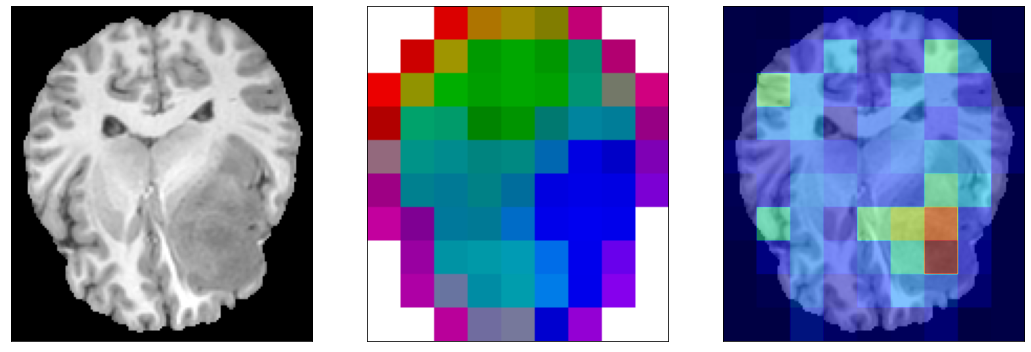

In [21]:
z = 70  # z-axis slice to visualize
mhsa_ind = 13  # MHSA head index for vis

# create volumes, adjust these paths to your created folders!
img, pca_vol = vis_pca('example_imgs/BraTS_T1_PCA', resize=1.0)
mhsa_vol = nib.load(f'example_imgs/BraTS_T1_MHSA/nifti_{mhsa_ind}.nii.gz').get_fdata()
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for ax in fig.axes:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
# display volumes
axs[0].imshow(np.rot90(img[:, :, z]), cmap='gray')
axs[1].imshow(np.rot90(pca_vol[:, :, z, :]))
axs[2].imshow(np.rot90(img[:, :, z]), cmap='gray')
axs[2].imshow(np.rot90(mhsa_vol[:, :, z]), cmap='jet', alpha=0.5)

plt.tight_layout()
plt.show()